In [2]:
import tensorflow as tf
print("GPU:", tf.config.list_physical_devices('GPU'))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# GPU 메모리 점유를 필요한 만큼만 하도록 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled.")
    except RuntimeError as e:
        print("❌ RuntimeError:", e)

✅ GPU memory growth enabled.


In [7]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# 데이터 불러오기
os.chdir("C:/Users/401-09/Desktop/유전자_dl")
df = pd.read_csv("data/dl_dataset_top100.csv")

# 피처만 추출
X = df.drop(columns=['sample', 'group'])  # 필요시 'label'도 drop

# log1p 변환
X_log = np.log1p(X)

# 정규화
X_scaled = StandardScaler().fit_transform(X_log)

# TensorFlow용 tensor 변환
X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

input_dim = X_tensor.shape[1]
encoding_dim = 16  # 최종 압축 차원 (latent)

# 인코더
input_layer = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(input_layer)     # 입력 정제 (확장)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)                # 중간 압축
x = Dropout(0.3)(x)
encoded = Dense(encoding_dim, activation='relu')(x)  # latent vector

# 디코더
x = Dense(64, activation='relu')(encoded)           # 복원 시작
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)                # 원래 차원에 근접
decoded = Dense(input_dim, activation='linear')(x)  # 출력

# 모델 정의
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 비선형 차원 축소 + 재구성에 적당한 shallow AE

# 튜닝 방향
# 32 → 16이나 8로 더 압축해보고 성능 확인: 적게 줄수록 추상화↑, 복원은 어려워짐
#  구조 확장 (hidden layer 추가): 좀 더 깊은 표현력 원할 때 효과적

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
]

history = autoencoder.fit(
    X_tensor, X_tensor,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
2/2 [==============================] - 0s 89ms/step - loss: 1.0491 - val_loss: 0.8716 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 13ms/step - loss: 1.0253 - val_loss: 0.8764 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 20ms/step - loss: 1.0158 - val_loss: 0.8792 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 20ms/step - loss: 1.0071 - val_loss: 0.8798 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 34ms/step - loss: 1.0045 - val_loss: 0.8795 - lr: 0.0010
Epoch 6/100
1/2 [==============>...............] - ETA: 0s - loss: 1.1311
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [==============================] - 0s 32ms/step - loss: 0.9877 - val_loss: 0.8781 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 33ms/step - loss: 0.9721 - val_loss: 0.8761 - lr: 5.0000e-04
Epoch 8/100
2/2 [==============================] - 0s 22ms/step - loss: 0.9683 - 

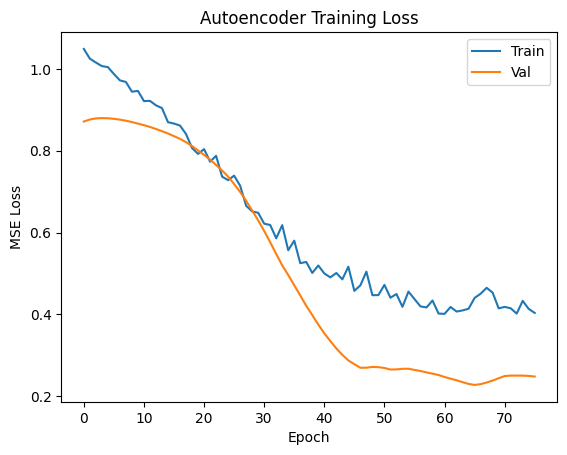

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss") # reconstruction error로 이상치 탐지용으로 활용 가능
plt.show()

In [15]:
# Latent feature 추출
encoder = Model(inputs=input_layer, outputs=encoded)
X_encoded = encoder.predict(X_tensor)

# 입력: 정규화된 발현값(63, 100)
# 출력: 잠재표현(lantent vector) (63, 16)
# 역할: 차원 축소된 AE 표현 => SVM, t-SNE, KMeans에 사용 가능, 클러스터링, 시각화, 분류 등 응용 가능

2/2 [==============================] - 0s 0s/step


In [16]:
X_reconstructed = autoencoder.predict(X_tensor)
recon_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)
df['recon_error'] = recon_error

# 입력: 원본 vs 재구성
# 출력: 샘플 단위 오류값(mse) (63,)
# 역할: 이상치 탐지, AE-based novlty detection에 활용 가능
# 응용: Stroke vs Control의 재구성 오차 차이 => 통계검정 or 시각화 가능

2/2 [==============================] - 0s 2ms/step



=== Logistic Regression ===
              precision    recall  f1-score   support

     Control       0.71      1.00      0.83         5
      Stroke       1.00      0.75      0.86         8

    accuracy                           0.85        13
   macro avg       0.86      0.88      0.85        13
weighted avg       0.89      0.85      0.85        13

Sensitivity (Recall+): 0.750
Specificity (Recall−): 1.000
AUC: 0.800


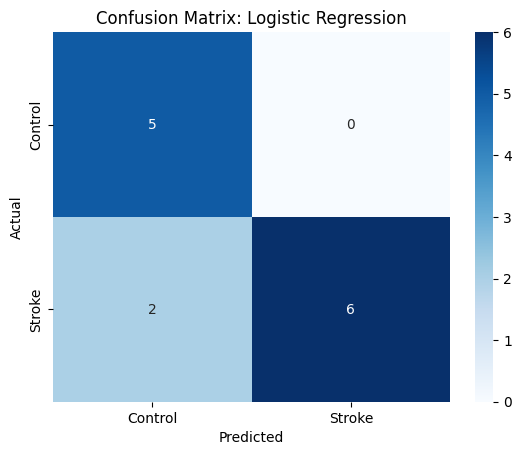


=== SVM (Linear) ===
              precision    recall  f1-score   support

     Control       0.71      1.00      0.83         5
      Stroke       1.00      0.75      0.86         8

    accuracy                           0.85        13
   macro avg       0.86      0.88      0.85        13
weighted avg       0.89      0.85      0.85        13

Sensitivity (Recall+): 0.750
Specificity (Recall−): 1.000
AUC: 0.775


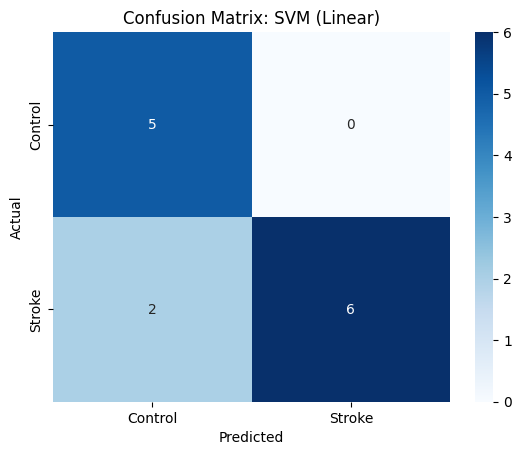


=== Random Forest ===
              precision    recall  f1-score   support

     Control       0.71      1.00      0.83         5
      Stroke       1.00      0.75      0.86         8

    accuracy                           0.85        13
   macro avg       0.86      0.88      0.85        13
weighted avg       0.89      0.85      0.85        13

Sensitivity (Recall+): 0.750
Specificity (Recall−): 1.000
AUC: 0.963


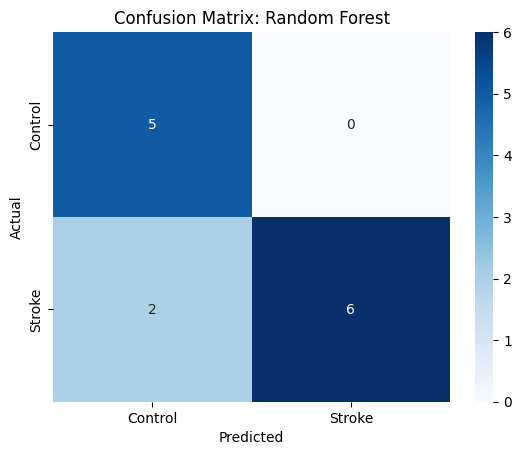


모델 성능 비교:


,Model,Accuracy,Sensitivity,Specificity,Precision,F1,AUC
0,Logistic Regression,0.846,0.75,1.0,1.0,0.857,0.800
1,SVM (Linear),0.846,0.75,1.0,1.0,0.857,0.775
2,Random Forest,0.846,0.75,1.0,1.0,0.857,0.962


In [17]:
# SVM / Logistic 분류 (X_encoded → group) ** 정량적으로 AE latent가 얼마나 유의미한지 바로 판단가
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === 1. 분류용 데이터 준비 ===
le = LabelEncoder()
y = le.fit_transform(df['group'])  # Stroke=1, Control=0

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# === 2. 사용할 모델들 정의 ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (Linear)": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# === 3. 평가 함수 정의 ===
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)  # Recall for Positive
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Sensitivity (Recall+): {sensitivity:.3f}")
    print(f"Specificity (Recall−): {specificity:.3f}")
    print(f"AUC: {auc:.3f}")
    
    # Confusion matrix 시각화
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        "Model": name,
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "F1": f1,
        "AUC": auc
    }

# === 4. 모델 평가 루프 ===
results = []
for name, model in models.items():
    metrics = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(metrics)

# === 5. 결과 비교 테이블 출력 ===
results_df = pd.DataFrame(results)
print("\n모델 성능 비교:")
display(results_df.sort_values(by="Accuracy", ascending=False).round(3))

# Accuracy 84.6%	전체 예측 정확도	균형 잘 맞음
# Sensitivity 75%	Stroke 감지율	일부 Stroke를 놓침 (FN 존재)
# Specificity 100%	Control 감지 완벽	Control은 전부 맞춤
# Precision 100%	Stroke라고 한 건 전부 맞았음	False Positive 없음
# AUC (RF: 0.962)	예측 신뢰도 + 분리 능력	분리 성능 거의 완벽

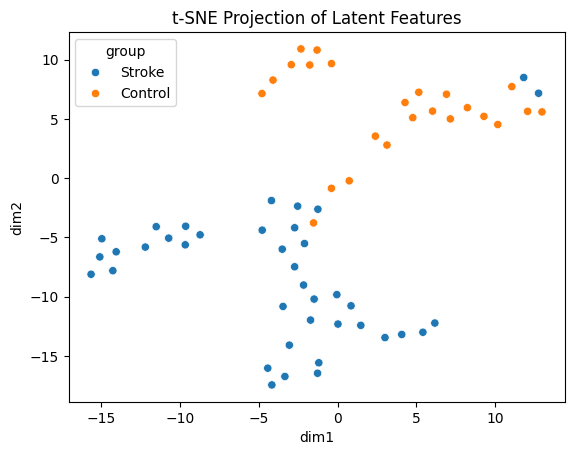

In [18]:
# t-SNE 시각화
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

df_tsne = pd.DataFrame(X_tsne, columns=['dim1', 'dim2'])
df_tsne['group'] = df['group'].values

sns.scatterplot(data=df_tsne, x='dim1', y='dim2', hue='group')
plt.title("t-SNE Projection of Latent Features")
plt.show()

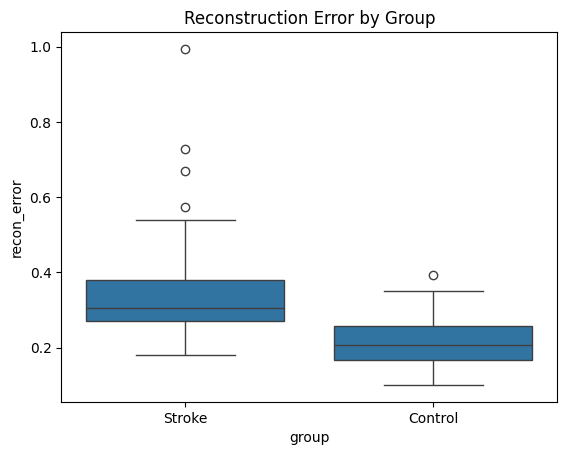

In [19]:
# 재구성 오차 시각화 (Stroke vs Control 차이)
sns.boxplot(data=df, x='group', y='recon_error')
plt.title("Reconstruction Error by Group")
plt.show()

<Figure size 640x480 with 0 Axes>

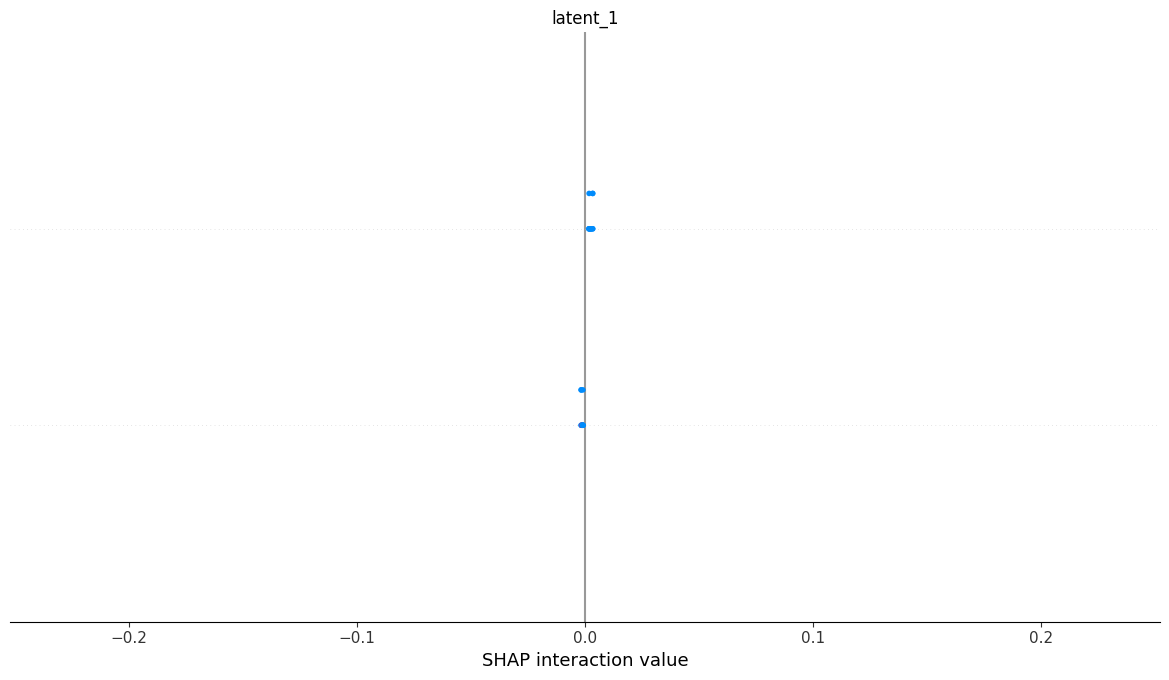

In [22]:
# 모델 설명력 해석 (SHAP)
import shap
import matplotlib.pyplot as plt

# 랜덤포레스트 모델 다시 학습 (or 기존 model 사용)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# SHAP explainer 초기화
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

# 요약 플롯 (전체 feature 중요도)
shap.summary_plot(shap_values.values, X_test, feature_names=[f"latent_{i}" for i in range(X_test.shape[1])])
# SHAP summary plot: 각 feature가 예측에 미치는 방향성과 크기

In [21]:
# Permutation Importance(모델 불가지론적 해석법)
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)

# 정리해서 출력
import pandas as pd
perm_df = pd.DataFrame({
    'Feature': [f"latent_{i}" for i in range(X_test.shape[1])],
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_df.head(10))
# Permutation importance: 해당 feature가 없을 떄 성능이 얼마나 떨어지는지

    Feature  Importance
2  latent_2    0.035897
4  latent_4    0.035897
0  latent_0    0.000000
1  latent_1    0.000000
3  latent_3    0.000000
5  latent_5    0.000000
6  latent_6    0.000000
7  latent_7    0.000000
8  latent_8    0.000000
9  latent_9    0.000000


In [ ]:
# 위의 두 결과를 보면 lantent vector 차원이 너무 작거나 flat해서 SHAP 정보도 추출해내지 못하고 있고 모델(RF) 자체가 별루...

In [23]:
# 다른 모델로 PI
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# 시각화
import pandas as pd
perm_df = pd.DataFrame({
    'Feature': [f"latent_{i}" for i in range(X_test.shape[1])],
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_df)

      Feature  Importance
2    latent_2    0.123077
4    latent_4    0.020513
15  latent_15    0.007692
0    latent_0    0.000000
1    latent_1    0.000000
3    latent_3    0.000000
5    latent_5    0.000000
6    latent_6    0.000000
7    latent_7    0.000000
8    latent_8    0.000000
9    latent_9    0.000000
10  latent_10    0.000000
11  latent_11    0.000000
12  latent_12    0.000000
13  latent_13    0.000000
14  latent_14    0.000000
